In [46]:
%load_ext autoreload
%autoreload 2
%load_ext functionizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The functionizer extension is already loaded. To reload it, use:
  %reload_ext functionizer


In [47]:
def save_fig(fig, name):
    fig.savefig(rf"C:\Users\wuyua\OneDrive - The University of Western Ontario\Research\crm\paper\figure\{name}.png", bbox_inches="tight")

In [192]:
from solvers import breakage_pa_2d, breakage_grid_2d, DaughterGridType
from compress import compress
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from scipy.integrate import trapz
from scipy.stats import binned_statistic, binned_statistic_2d, norm
import pandas as pd
import matplotlib
import plotly.express as px
import plotly.graph_objects as go

In [193]:

L_edges_0 = np.linspace(0, 10, 51)
L_edges_1 = np.linspace(0, 10, 50)
L_edges = (L_edges_0, L_edges_1)
L_edge_diff_area = (L_edges_0[1] - L_edges_0[0]) * (L_edges_1[1] - L_edges_1[0])

L_centers_0 = 0.5 * (L_edges_0[:-1] + L_edges_0[1:])
L_centers_1 = 0.5 * (L_edges_1[:-1] + L_edges_1[1:])

L_centers = (L_centers_0, L_centers_1)
Lc0, Lc1 = np.meshgrid(*L_centers)
Lc = np.stack([Lc0, Lc1], axis=-1)
z = (Lc0 ** 2 + Lc1 ** 2) ** (1/2)

n_init = norm.pdf(Lc0, loc=8, scale=3) * norm.pdf(Lc1, loc=8, scale=3)

dt = 1.
t_total = 30.
kernel_coef = np.array([1e-7, 1e-7])
brk_powers = np.array([2., 1.])

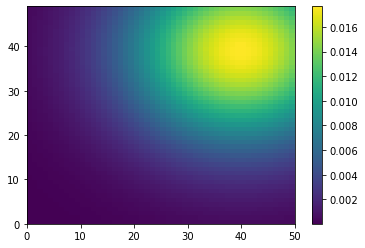

In [194]:
plt.pcolor(n_init)
plt.colorbar()

In [195]:
t = 0
n = n_init.copy()
cnt = (n * L_edge_diff_area).sum()
vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()
cnts = [cnt]
vols = [vol]
ts = [t]

pbar = tqdm(total=t_total)
while t < t_total:
    B, D = breakage_grid_2d(n, L_edges, L_centers, kernel_coef, brk_powers)
    n += (B - D) * dt
    assert np.all(n >= 0)
    t += dt
    # assert np.isclose(B.sum() * 2, D.sum())
    pbar.update(dt)
    cnt = (n * L_edge_diff_area).sum()
    vol = (n * Lc0**2 * Lc1 * L_edge_diff_area).sum()
    cnts.append(cnt)
    vols.append(vol)
    ts.append(t)
    # break
pbar.close()

  0%|          | 0/30.0 [00:00<?, ?it/s]

C:\Users\wuyua\Projects\PycharmProjects\mvg\solvers.py:544: NumbaExperimentalFeatureWarning: First-class function type feature is experimental
  coef = kernel_fcn(vi) * kernel_coef


In [196]:
N_init = n_init * L_edge_diff_area
N = np.vstack([Lc0.reshape(-1), Lc1.reshape(-1), N_init.reshape(-1)]).T
N = N[N[:, -1] > 0*L_edge_diff_area]
N_init = N.copy()
pbar = tqdm(total=t_total)
t = 0
pa_cnts = [N[:, -1].sum()]
pa_ts = [t]
pa_vols = [(N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()]
while t < t_total:
    v_original = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    Bs, D = breakage_pa_2d(N, kernel_coefs=kernel_coef, dim_powers=brk_powers, min_count=1e-15, daughter_grid_type=DaughterGridType.LINEAR)
    B = np.vstack(Bs)
    assert np.isclose(D.sum()*2, B[:, -1].sum()) # count rate equal
    assert np.isclose((N[:, 0]**2 * N[:, 1] * D).sum(), (B[:, 0]**2 * B[:, 1] * B[:, -1]).sum())
    N[:, -1] -= dt * D
    assert np.all(N[:, -1] > 0)
    B[:, -1] *= dt

    N = np.vstack((N, B))
    v_before_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_original)
    N = compress(N, 1.0, brk_powers, 1, )
    v_after_compression = (N[:, 0]**2 * N[:, 1] * N[:, -1]).sum()
    assert np.isclose(v_before_compression, v_after_compression)
    t += dt
    pbar.update(dt)
    pa_cnts.append(N[:, -1].sum())
    pa_ts.append(t)
    pa_vols.append(v_after_compression)
pbar.close()

  0%|          | 0/30.0 [00:00<?, ?it/s]

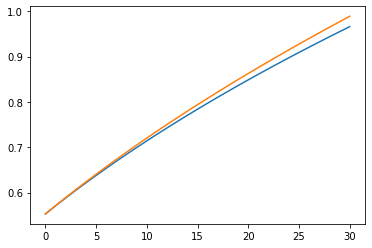

In [197]:
fig, ax = plt.subplots()
ax.plot(pa_ts, pa_cnts)
ax.plot(ts, cnts)

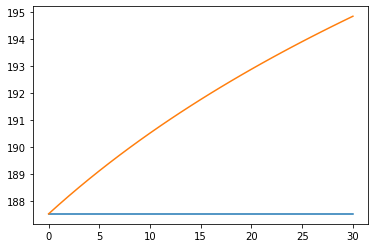

In [189]:
fig, ax = plt.subplots()
ax.plot(pa_ts, pa_vols)
ax.plot(ts, vols)
ax.ticklabel_format(style="plain", useOffset=False)